# Model Training notebook

Contains the whole pipeline to train the models.  
How to use:   

Run the first cells to import all needed models and functions  
Then run the cell that loads the weights, if none are present it will create a new model  
Run the training cell and adjust N and iterations accordingly. Using a higher N will use more RAM, so you can lower N and augment iterations.  
Finally if the results are are good, you can save the model weigths. Only do it if the results are nice, because it overwrites the old weigths. 
The last cell vizualizes 3 different reference images with very different D values. 

In [4]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 16    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 20000        # Diffusion coefficient in nm^2 per s (=0.000001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !
n_val_im = 50


In [13]:
%reload_ext autoreload
%autoreload 2
from helpers import *
from modelsUtils import *
from simpleCNNModel import *
from ResNetModel2D import *
from ResNetModel3D import *
from paperCNN import *
from paperCNNNoPooling import *
import os.path

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [6]:
# Models used in a dictionnary comprehension. 
# To add  anew model, simply add it to the list with the wanted train fct

lr = 0.000001
models_params = {
    #"simpleCNN": {"class": SimpleCNN, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "resNet2D": {"class": ResNet2D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    #"resNet3D": {"class": ResNet3D, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    "paperCNNAdam": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" : lr},
    #"paperCNNSGD": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "sgd", "lr" :lr},
    #"paperCNNNoPool": {"class": PaperCnn, "train_fct": train_model, "loaded_model": None, "criterion": nn.MSELoss(), "optimizer" : "adam", "lr" :lr}
    
}

In [7]:
for name, params in models_params.items():
    class_ = params["class"]
    # Load the model weights
    loaded_model = class_().to(device)
    filename = "w_" + name + ".pth"
    if os.path.exists(filename):
        loaded_model = load_model_weights(loaded_model, filename)
        print(name, "Loaded existing weights")
    else:
        print(name, "Did not find weights, loaded a new model")
        
    params["loaded_model"] = loaded_model  # Update the dictionary with the loaded model
    
    if(isinstance(params["optimizer"],str)):
        if params["optimizer"] == "adam":
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])
        elif params["optimizer"] == "sgd":
            params["optimizer"] = optim.SGD(loaded_model.parameters(), lr=params["lr"], momentum=0.9)
        else: 
            params["optimizer"] = optim.Adam(loaded_model.parameters(), lr=params["lr"])

Model weights loaded from w_resNet2D.pth
resNet2D Loaded existing weights
Model weights loaded from w_paperCNNAdam.pth
paperCNNAdam Loaded existing weights


In [8]:
# run this cell to reset loss histories
totalEpochs = 0
tr_loss_histories = {name: [] for name in models_params.keys()}
val_loss_histories = {}

for name, params in models_params.items():

    filename = "l_" + name + ".npy"
    if os.path.exists(filename):
        val_loss_histories[name] = np.load(filename)
        print(name, "Loaded existing losses")
        totalEpochs = len(val_loss_histories[name])
    else:
        print(name, "Did not find losses, loaded an empty array")
        val_loss_histories[name] = np.array([])

ds = "allDs.npy"
if os.path.exists(ds):
    allGeneratedDs = np.load(ds)
else:
    allGeneratedDs = np.array([])   



resNet2D Loaded existing losses
paperCNNAdam Loaded existing losses


In [9]:
# load validation images
val_trajs = np.load('validation_trajectories.npy')
val_images, valDs = generateImagesAndEstimateDFromTrajs(val_trajs,n_val_im, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
valDs = torch.tensor(valDs/1000, dtype=torch.float32, device=device)

In [18]:
epochs = 1
N = 16 # Number of samples per iteration
verbose = False # print in console
for i in range(epochs):

    print(f"Generating images for iteration: {i}")

    images, estimatedDs =  generateImagesAndEstimateDMAXD(N, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
    
    # Divide the estimateDs by 10000 to get values in the range 0.5->70, then add them to the list of all Ds
    estimatedDs = estimatedDs / 1000
    allGeneratedDs = np.append(allGeneratedDs,estimatedDs)
    

    # Add channel dimension to images: (N, 16, 64, 64) -> (N, 16, 1, 64, 64)
    images = torch.tensor(images, dtype=torch.float32).unsqueeze(2)
    estimatedDs = torch.tensor(estimatedDs, dtype=torch.float32)


    for name, params in models_params.items():
        model = params["loaded_model"]
        train_fct = params["train_fct"]
        criterion = params["criterion"]
        optimizer = params["optimizer"]
        if(verbose):
            print("Training model:" , name)
        trained_model, tr_loss_history = train_fct(model, images, estimatedDs, device, criterion, optimizer, epochs=1, batch_size=16)
        params["loaded_model"] = trained_model

        # Compute validation loss on fixed set of images
        model_preds = predict_diffusion_coefficients(trained_model, val_images ,device)
        if(name == 'paperCNNSGD'):
            print(model_preds)
        loss = criterion(model_preds, valDs)
        val_loss_histories[name] = np.append(val_loss_histories[name],loss.item())



        # Store the single training epoch loss
        if isinstance(tr_loss_history, list) and len(tr_loss_history) > 0:
            tr_loss_histories[name].append(tr_loss_history[-1])  # Append last loss in the history
        elif isinstance(tr_loss_history, (float, int)):  # If it's a single loss value
            tr_loss_histories[name].append(tr_loss_history)
        else:
            print(f"Unexpected loss format for model {name}: {tr_loss_history}")

# add up epochs for later use 
totalEpochs = totalEpochs + epochs



Generating images for iteration: 0


Generating trajectories: 100%|██████████| 16/16 [00:01<00:00,  8.24it/s]


running program on each 12 cpu core of the computer


Generating images and estimating D: 100%|██████████| 16/16 [00:03<00:00,  4.60it/s]


tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan])


1.1442691862332344
20.039715252882203
200.8046772627592


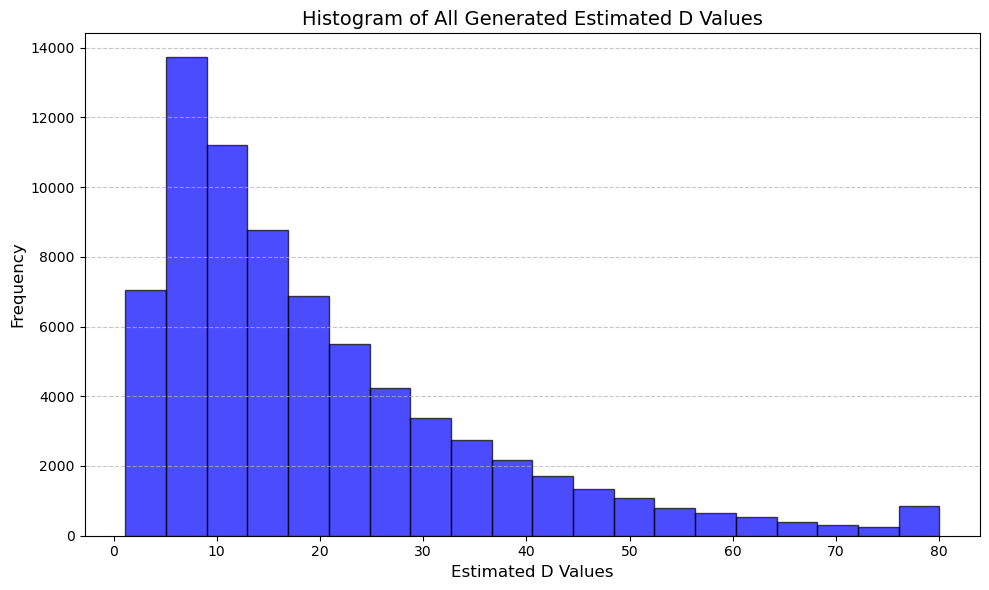

In [10]:

print(np.min(allGeneratedDs))
print(np.mean(allGeneratedDs))
print(np.max(allGeneratedDs))

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(np.clip(allGeneratedDs,0,80), bins=20, color='blue', edgecolor='black', alpha=0.7)

# Add labels, title, and grid
plt.xlabel('Estimated D Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of All Generated Estimated D Values', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()


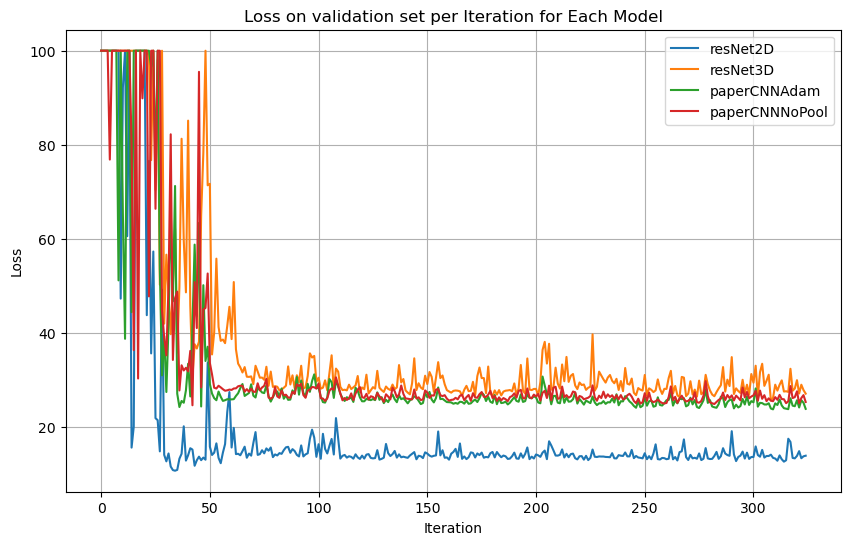

C:\Users\Emilien\AppData\Local\Temp\ipykernel_9480\3109743138.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valDs_tensor = torch.tensor(valDs, dtype=model_preds.dtype, device=model_preds.device)


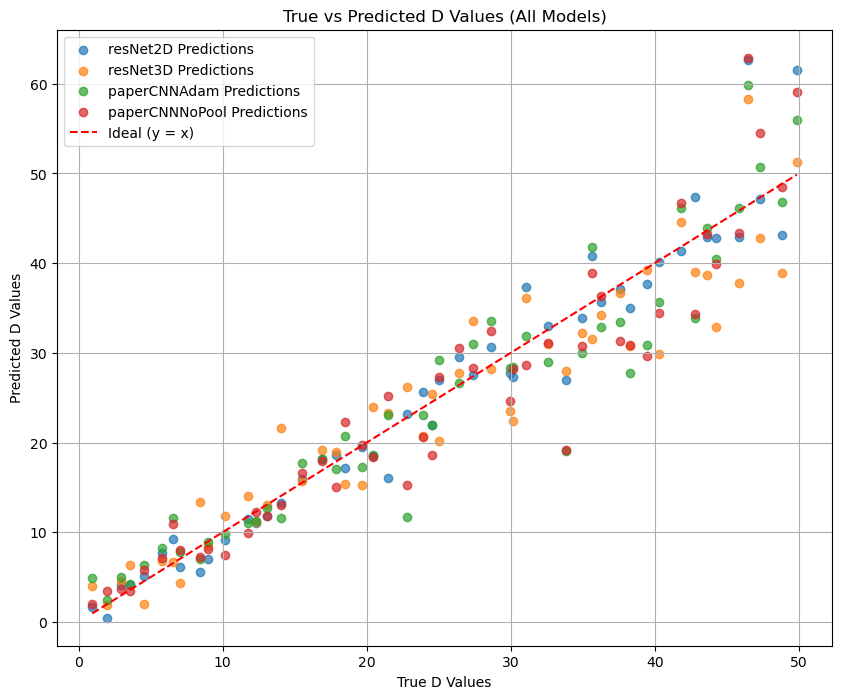

In [24]:
plt.figure(figsize=(10, 6))
for model_name, losses in val_loss_histories.items():
    plt.plot(range(0, totalEpochs ), np.clip(losses,0,100), label=model_name)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss on validation set per Iteration for Each Model')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))

# Iterate over all models to plot predictions vs true values
for name, params in models_params.items():
    # Predictions and true values
    model = params["loaded_model"]
    model_preds = predict_diffusion_coefficients(model, val_images, device)
    valDs_tensor = torch.tensor(valDs, dtype=model_preds.dtype, device=model_preds.device)
    
    # Ensure predictions and true values are on the same device and flattened
    model_preds = model_preds.view(-1).cpu().numpy()  # Convert to numpy for plotting
    valDs_array = valDs_tensor.view(-1).cpu().numpy()  # Convert to numpy for plotting

    # Scatter plot for the current model
    plt.scatter(valDs_array, model_preds, alpha=0.7, label=f'{name} Predictions')

# Plot the ideal line
min_val, max_val = min(valDs_array), max(valDs_array)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y = x)')

# Add plot details
plt.title("True vs Predicted D Values (All Models)")
plt.xlabel("True D Values")
plt.ylabel("Predicted D Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Coase D Loss: 28.59381103515625


C:\Users\Silly Emilien\AppData\Local\Temp\ipykernel_18056\2741621993.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valDs_tensor = torch.tensor(valDs, dtype=model_preds.dtype, device=model_preds.device)


Model: resNet2D Loss without rotation: 14.948208808898926 Loss with rotation 12.185673713684082
Model: paperCNNAdam Loss without rotation: 24.123281478881836 Loss with rotation 17.573684692382812


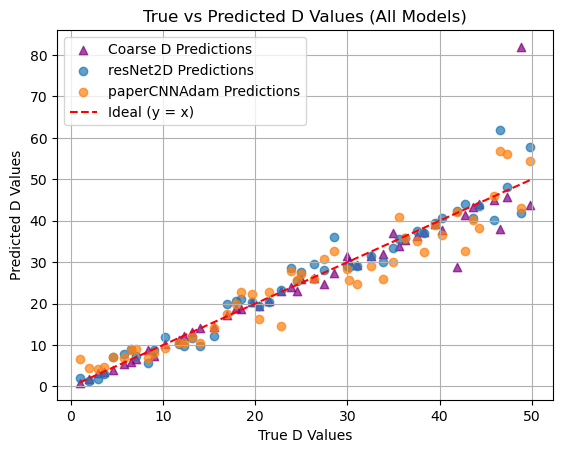

In [25]:
# Initialize a vector to store the average predictions across all models
#average_predictions = torch.zeros_like(valDs_tensor, dtype=torch.float32, device=device)
#average_predictionsRot = torch.zeros_like(valDs_tensor, dtype=torch.float32, device=device)
# Count the number of models contributing to the average
model_count = 0

coarseD_tensor = torch.tensor(compute_coarseD_for_batch(val_images, dt), dtype=torch.float32, device=device) / 40
#coarseD_tensor = torch.clip(coarseD_tensor,0,60)
lossCoarseD = criterion(coarseD_tensor, valDs_tensor)  # Loss for coarseD predictions
coarseD_array = coarseD_tensor.view(-1).cpu().numpy()  # Convert to numpy for plotting
plt.scatter(valDs_array, coarseD_array, color='purple', alpha=0.7, label='Coarse D Predictions', marker='^')
print("Coase D Loss:", lossCoarseD.item())


# Iterate over all models to plot predictions vs true values
for name, params in models_params.items():
    # Predictions and true values
    model = params["loaded_model"]
    criterion = params["criterion"]
    model_preds = predict_diffusion_coefficients(model, val_images, device)
    model_predsRot, individualPreds = predict_with_rotations(model, val_images, device)
    valDs_tensor = torch.tensor(valDs, dtype=model_preds.dtype, device=model_preds.device)

    # Add predictions to the average vector
    #average_predictions += model_preds
    #average_predictionsRot += model_predsRot
    model_count += 1



    # Compute losses
    loss = criterion(model_preds, valDs)
    lossRot = criterion(model_predsRot, valDs)
    # Ensure predictions and true values are on the same device and flattened
    model_preds = model_preds.view(-1).cpu().numpy()  # Convert to numpy for plotting
    model_predsRot = model_predsRot.view(-1).cpu().numpy()  # Convert to numpy for plotting
    valDs_array = valDs_tensor.view(-1).cpu().numpy()  # Convert to numpy for plotting
    # Scatter plot for the current model
    print("Model:", name, "Loss without rotation:", loss.item(), "Loss with rotation", lossRot.item())
    plt.scatter(valDs_array, model_predsRot, alpha=0.7, label=f'{name} Predictions')




"""
# Calculate the average predictions
average_predictions /= model_count
average_predictionsRot /= model_count

loss = criterion(average_predictions, valDs)
lossRot = criterion(average_predictionsRot, valDs)

print("Model:", "Average", "Loss without rotation:", loss.item(), "Loss with rotation", lossRot.item())

# Convert average predictions to numpy for plotting
average_predictions_np = average_predictions.view(-1).cpu().numpy()
average_predictions_npRot = average_predictionsRot.view(-1).cpu().numpy()

# Scatter plot for the average predictions
plt.scatter(valDs_array, average_predictions_np, color='orange', alpha=0.9, label='Average Predictions', marker='x')
plt.scatter(valDs_array, average_predictions_npRot, color='yellow', alpha=0.9, label='Average Predictions', marker='x')
"""


# Plot the ideal line
min_val, max_val = min(valDs_array), max(valDs_array)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y = x)')

# Add plot details
plt.title("True vs Predicted D Values (All Models)")
plt.xlabel("True D Values")
plt.ylabel("Predicted D Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


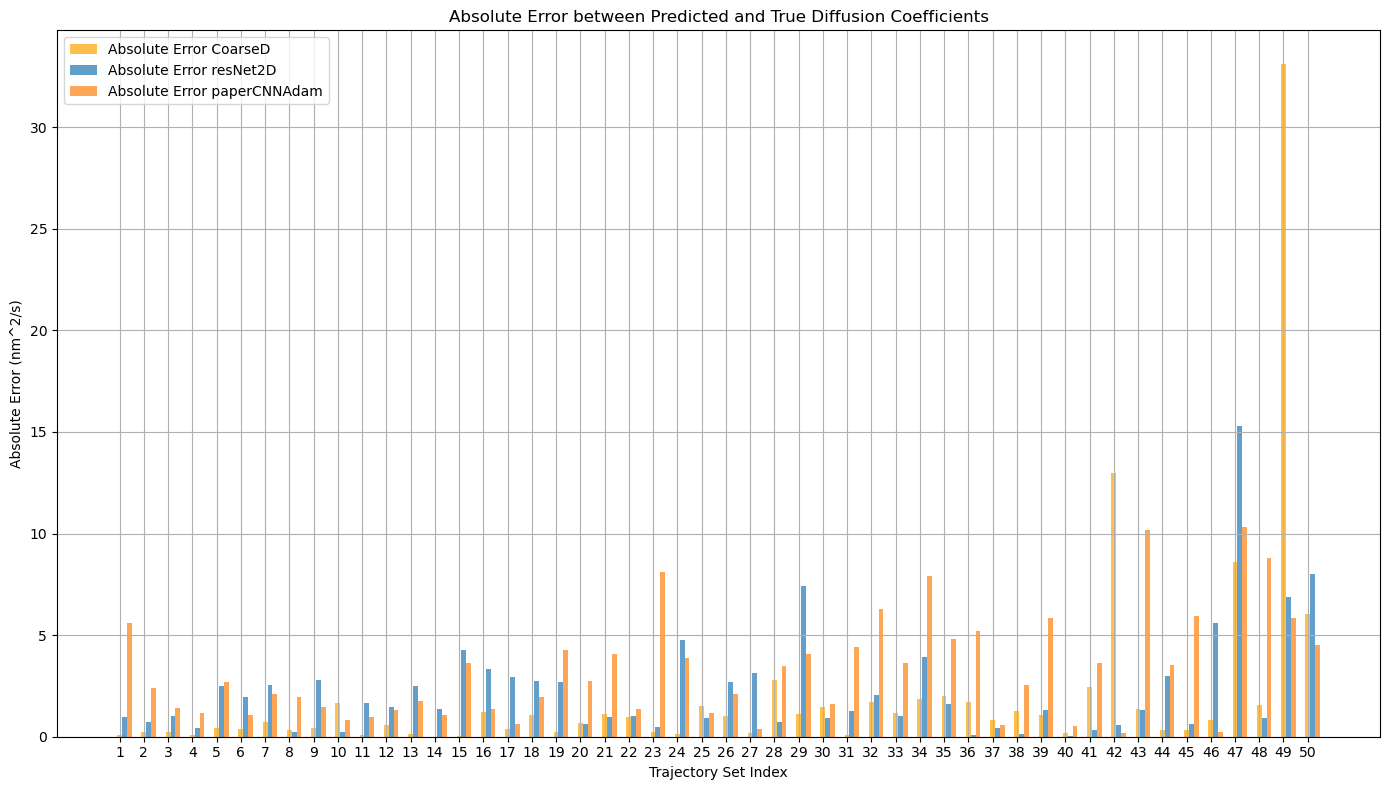

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Absolute error for coarseD
absolute_error_coarseD = np.abs(coarseD_array - valDs_array)

# Number of trajectory sets
num_trajectories = len(valDs_array)

# Define bar width and positions
bar_width = 0.2
x_indices = np.arange(1, num_trajectories + 1)  # Trajectory indices
offset = 0  # Offset for each bar group

# Initialize the figure
plt.figure(figsize=(14, 8))

# Plot absolute error for coarseD
plt.bar(
    x_indices + offset,
    absolute_error_coarseD,
    width=bar_width,
    label="Absolute Error CoarseD",
    alpha=0.7,
    color='orange'
)
offset += bar_width  # Update offset for the next group

# Iterate over all models to plot absolute errors
for name, params in models_params.items():
    # Predictions from the model
    model = params["loaded_model"]
    model_predsRot, individualPreds = predict_with_rotations(model, val_images, device)
    model_predsRot = model_predsRot.view(-1).cpu().numpy()  # Convert to numpy for plotting

    # Calculate absolute error for the model
    absolute_error_model = np.abs(model_predsRot - valDs_array)

    # Plot the bar for the model
    plt.bar(
        x_indices + offset,
        absolute_error_model,
        width=bar_width,
        label=f"Absolute Error {name}",
        alpha=0.7
    )
    offset += bar_width  # Update offset for the next group

# Add labels, title, and legend
plt.xlabel("Trajectory Set Index")
plt.ylabel("Absolute Error (nm^2/s)")
plt.title("Absolute Error between Predicted and True Diffusion Coefficients")
plt.legend()
plt.grid(True)

# Adjust x-axis ticks to center bar groups
plt.xticks(x_indices + (offset - bar_width) / 2 - bar_width, x_indices)

# Show the plot
plt.tight_layout()
plt.show()


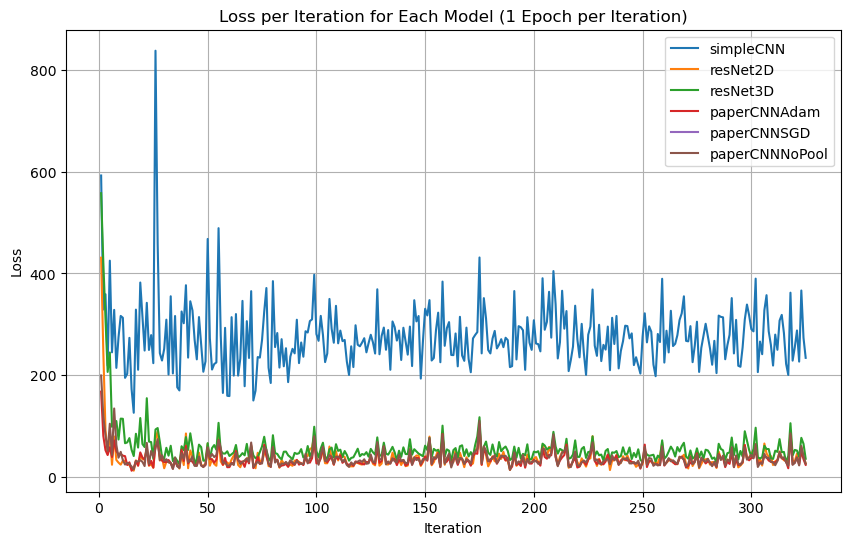

In [98]:

plt.figure(figsize=(10, 6))
for model_name, losses in tr_loss_histories.items():
    plt.plot(range(1, totalEpochs + 1), losses, label=model_name)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss per Iteration for Each Model (1 Epoch per Iteration)')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
# saves all used models 

for name, params in models_params.items():
    model = params["loaded_model"]
    filename = "w_"+name+".pth"
    save_model_weights(model,filename)

Model weights saved to w_simpleCNN.pth
Model weights saved to w_resNet2D.pth
Model weights saved to w_resNet3D.pth
Model weights saved to w_paperCNNAdam.pth
Model weights saved to w_paperCNNSGD.pth
Model weights saved to w_paperCNNNoPool.pth


In [100]:
# Save validation Loss and epochs
np.save("allDs.npy",allGeneratedDs)
for model_name, losses in val_loss_histories.items():
    filename = "l_"+model_name+".npy"
    np.save(filename,losses)

Image loaded from refImageSmall.npy
Real D value for image refImageSmall of model: simpleCNN : 1.9350. Model estimated value: 9.9311
Real D value for image refImageSmall of model: resNet : 1.9350. Model estimated value: 3.5535
Real D value for image refImageSmall of model: paperCNNAdam : 1.9350. Model estimated value: 1.8010
Real D value for image refImageSmall of model: paperCNNSGD : 1.9350. Model estimated value: 10.0318


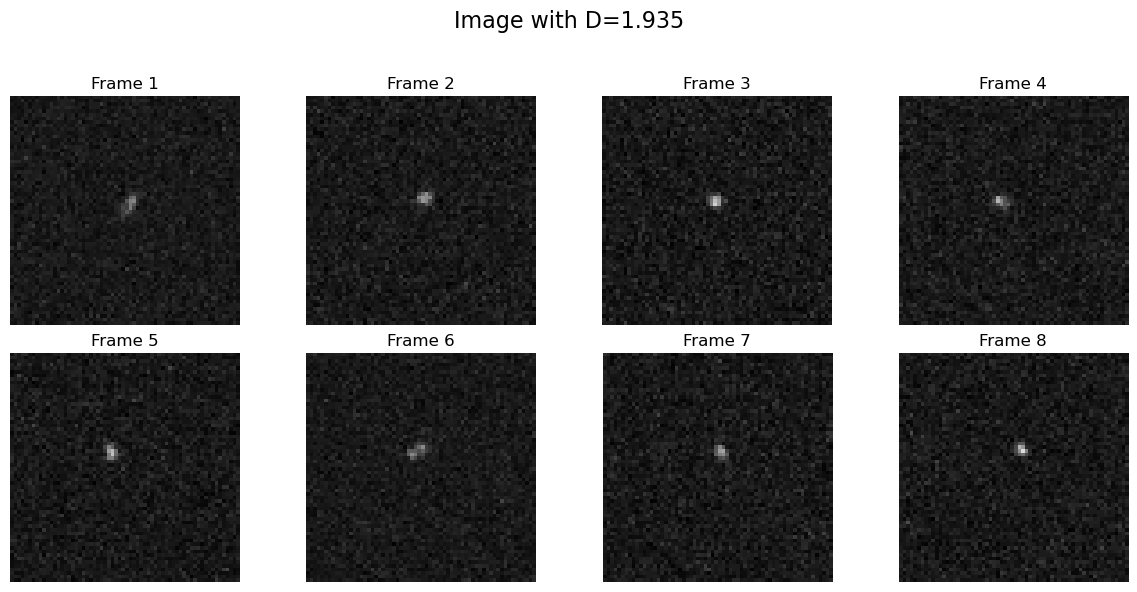

Image loaded from refImage.npy
Real D value for image refImage of model: simpleCNN : 13.8750. Model estimated value: 9.9311
Real D value for image refImage of model: resNet : 13.8750. Model estimated value: 9.6482
Real D value for image refImage of model: paperCNNAdam : 13.8750. Model estimated value: 14.2315
Real D value for image refImage of model: paperCNNSGD : 13.8750. Model estimated value: 10.0318


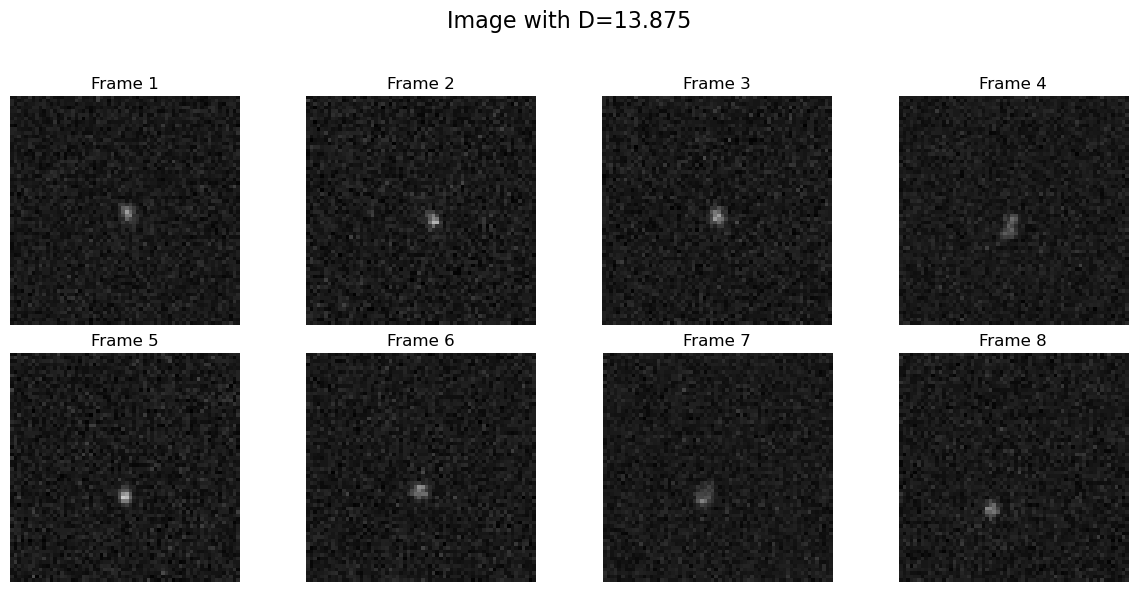

Image loaded from refImageBig.npy
Real D value for image refImageBig of model: simpleCNN : 26.0920. Model estimated value: 9.9311
Real D value for image refImageBig of model: resNet : 26.0920. Model estimated value: 35.0272
Real D value for image refImageBig of model: paperCNNAdam : 26.0920. Model estimated value: 22.5965
Real D value for image refImageBig of model: paperCNNSGD : 26.0920. Model estimated value: 10.0318


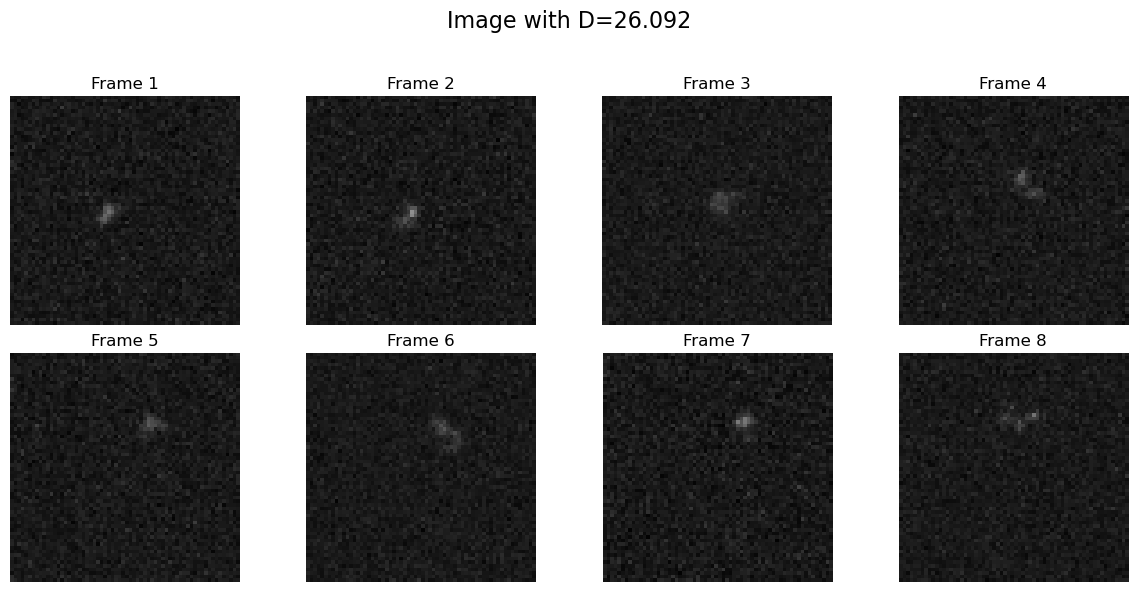

In [77]:
# Uncomment these 3 lines to generate a new reference image
#singleIm, singleestimatedDs = generateImagesAndEstimateD(1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
#im, estD = singleIm[0,:], singleestimatedDs[0]
#save_image(im,"refImageBig.npy") 


# We created 3 reference images, with different D values, to observe what our algorithm predicts
dict = {"refImageSmall": 1.935, "refImage": 13.875, "refImageBig": 26.092}

for iname, estD in dict.items():
    im = load_image(iname + ".npy")
    for mname, params in models_params.items():
        model = params["loaded_model"]

        modelEstimation = predict_diffusion_coefficients(model, im ,device)
        print(f"Real D value for image {iname} of model: {mname} : {estD:.4f}. Model estimated value: {modelEstimation:.4f}")

    plot_image_frames(im,f"Image with D={estD}")


In [ ]:
# run this code to generate new 50 reference images that will be used to compute the validation loss at each iteration
"""
parts = 10000
trajectories = brownian_motion(parts,nframes,nposframe,DGen,dt,False)
time_range = np.arange(nframes * nposframe) * dt / nposframe

nIm = 50

trajsToSave = np.zeros((nIm,nframes*nposframe,2))
saved = np.zeros(nIm)
print(saved)

for p in range(parts):
    traj = trajectories[p,:]
    msd = mean_square_displacement(traj)
    estimD = estimateDfromMSD(msd,time_range)


    index = int(estimD/1000)
    if(index < nIm and saved[index] == 0 ):
        saved[index] = 1
        trajsToSave[index,:] = traj

print(saved)
np.save('validation_trajectories.npy',trajsToSave)"""

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
